In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final AD JPEG/ADNI_037_S_4214_MR_Axial_T2_TSE_with_Fat_Sat__br_raw_20151016131541571_22_S285609_I527059.jpg
/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final AD JPEG/ADNI_941_S_4187_MR_AX_T2_STAR_br_raw_20160413145949114_22_S418013_I679910.jpg
/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final AD JPEG/ADNI_067_S_4782_MR_Axial_T2_STAR__br_raw_20170831100001045_22_S603944_I898549.jpg
/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final AD JPEG/ADNI_037_S_4302_MR_AX_T2_STAR_br_raw_20151202134651542_22_S321070_I568501.jpg
/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final AD JPEG/ADNI_109_S_4531_MR_Axial_T2_Star__br_raw_20150406152854152_22_S254469_I482398.jpg
/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final AD JPEG/ADNI_002_S_4521_MR_Axial_T2-Star__br_raw_20160324122521837_22_S402609_I662501.jpg


In [5]:
import os
base_dir = "../input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['Final EMCI JPEG', 'Final MCI JPEG', 'Final LMCI JPEG', 'Final CN JPEG', 'Final AD JPEG']


In [6]:
WORK_DIR = './dataset/'
CLASSES = [ 'Final EMCI JPEG',
            'Final CN JPEG',
            'Final LMCI JPEG',
            'Final MCI JPEG',
           'Final AD JPEG']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:
#Performing Image Augmentation to have more data samples
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6400, shuffle=False)

Found 1296 images belonging to 5 classes.


In [8]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [9]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(1296, 176, 176, 3) (1296, 5)


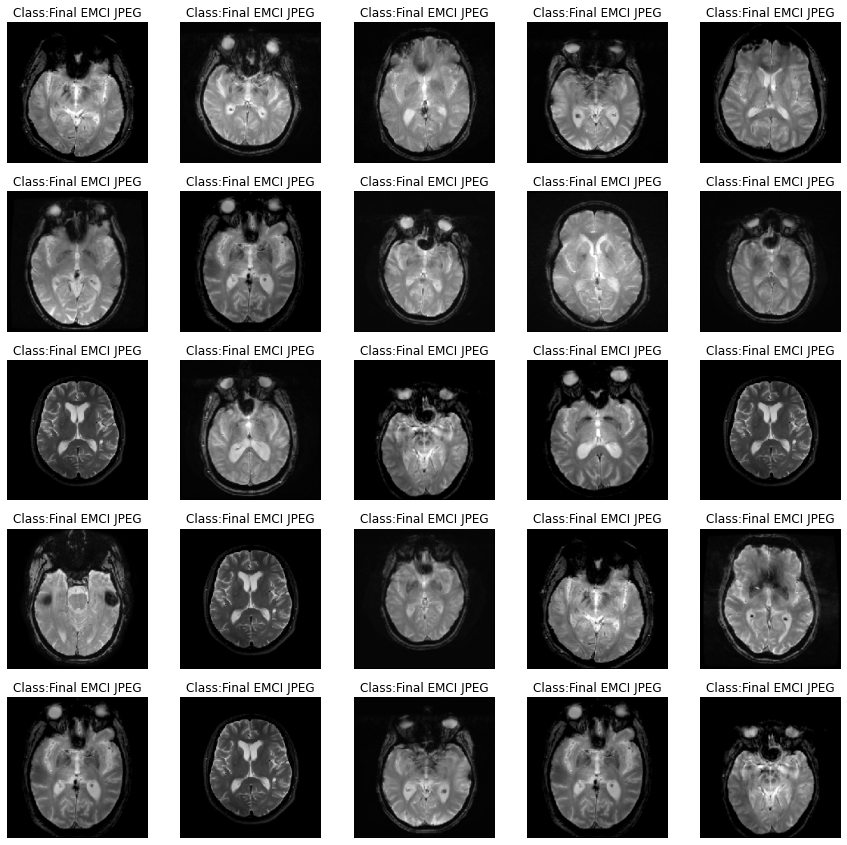

In [18]:
import matplotlib.pyplot as plt
from random import randint, random
import numpy as np
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(15, 15))
    if y_pred is None:
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            idx = randint(0, 31)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    
# Display Train Images
show_images(train_data_gen)

In [19]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import imblearn
print(imblearn.__version__)

0.8.0


In [22]:
from imblearn.over_sampling import SMOTE

In [23]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2900, 176, 176, 3) (2900, 5)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [24]:
#Splitting the data into train, test, and validation sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


In [25]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model = VGG19(input_shape=(176,176,3), 
                   include_top=False,
                   weights="imagenet")

80142336/80134624 [==============================] - 1s 0us/step


In [26]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [29]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

In [34]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12800)             51200     
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              26216448  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_2 (Activation)    (None, 2048)             

In [36]:
import tensorflow as tf
OPT    = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [32]:
import tensorflow as tf

tf.config.run_functions_eagerly(True)

In [37]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 5

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/5
58/58 [==============================] - 16s 266ms/step - loss: 2.0296 - auc: 0.6336 - val_loss: 1.3187 - val_auc: 0.7724
Epoch 2/5
58/58 [==============================] - 15s 257ms/step - loss: 1.2001 - auc: 0.8422 - val_loss: 1.0037 - val_auc: 0.8760
Epoch 3/5
58/58 [==============================] - 15s 256ms/step - loss: 0.8717 - auc: 0.9086 - val_loss: 0.9141 - val_auc: 0.8965
Epoch 4/5
58/58 [==============================] - 15s 258ms/step - loss: 0.6823 - auc: 0.9418 - val_loss: 0.8125 - val_auc: 0.9190
Epoch 5/5
58/58 [==============================] - 15s 256ms/step - loss: 0.5575 - auc: 0.9600 - val_loss: 0.7764 - val_auc: 0.9251


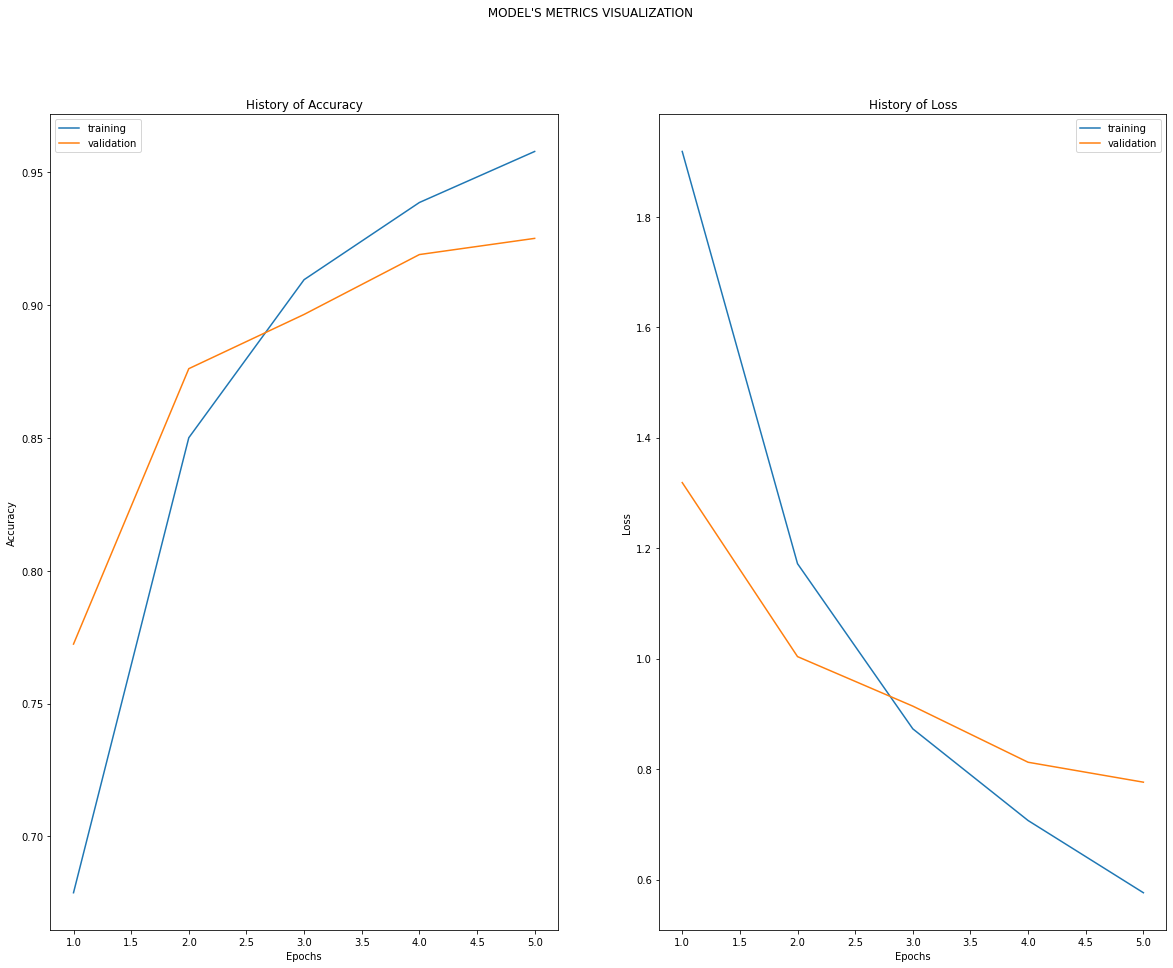

In [38]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,15))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['auc'],history.history['val_auc'],
               history.history['loss'],history.history['val_loss'])

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
pred_labels = model.predict(test_data)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

from sklearn.metrics import roc_auc_score
print("Accuracy is",roc_auc_score(test_labels, pred_labels))


[0. 1. 0. 0. 0.]
                 precision    recall  f1-score   support

Final EMCI JPEG       0.82      0.84      0.83       112
  Final CN JPEG       0.55      0.54      0.54       125
Final LMCI JPEG       0.73      0.70      0.72       117
 Final MCI JPEG       0.92      0.90      0.91       116
  Final AD JPEG       0.57      0.63      0.60       110

      micro avg       0.72      0.72      0.72       580
      macro avg       0.72      0.72      0.72       580
   weighted avg       0.72      0.72      0.72       580
    samples avg       0.72      0.72      0.72       580

Accuracy is 0.8245846498698016


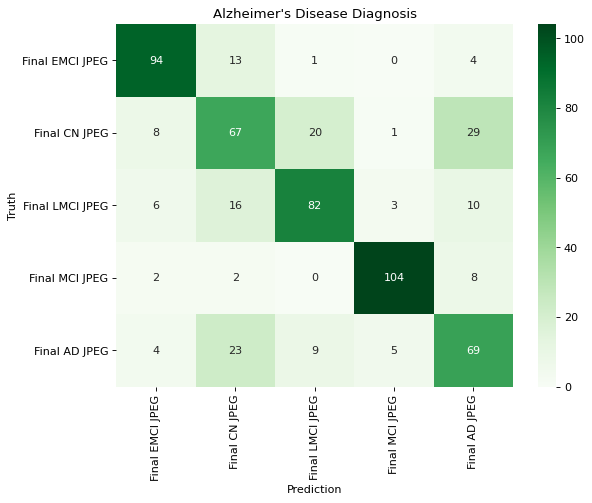

In [40]:
#Plot the confusion matrix to understand the classification in detail
import seaborn as sns
import matplotlib.pyplot as plt

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)